C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Epoch 1/20


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mariumbo\project-thesis\random_walk.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [train[-1]] * len(test)


234/234 [==============================] - 0s 698us/step - loss: 0.0159
Epoch 2/20
234/234 [==============================] - 0s 668us/step - loss: 0.0076
Epoch 3/20
234/234 [==============================] - 0s 636us/step - loss: 0.0051
Epoch 4/20
234/234 [==============================] - 0s 633us/step - loss: 0.0043
Epoch 5/20
234/234 [==============================] - 0s 627us/step - loss: 0.0039
Epoch 6/20
234/234 [==============================] - 0s 577us/step - loss: 0.0039
Epoch 7/20
234/234 [==============================] - 0s 636us/step - loss: 0.0038
Epoch 8/20
234/234 [==============================] - 0s 635us/step - loss: 0.0039
Epoch 9/20
234/234 [==============================] - 0s 637us/step - loss: 0.0038
Epoch 10/20
234/234 [==============================] - 0s 636us/step - loss: 0.0039
Epoch 11/20
234/234 [==============================] - 0s 627us/step - loss: 0.0039
Epoch 12/20
234/234 [==============================] - 0s 641us/step - loss: 0.0038
Epoch 13/20


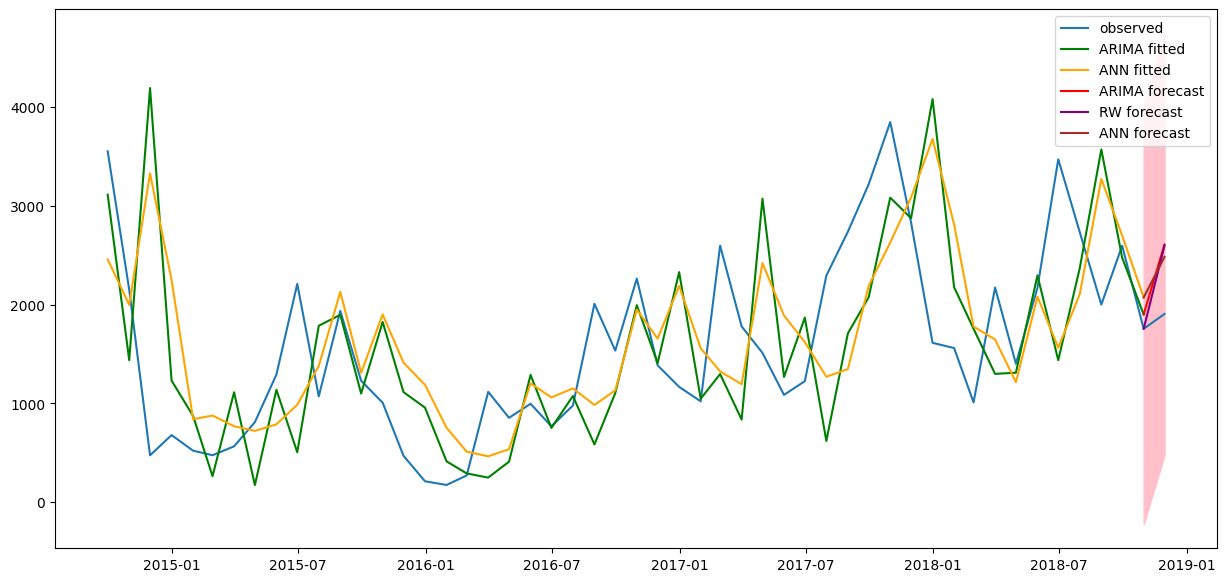

ARIMA MSE: 852.686276437068
RW MSE: 841.0


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Epoch 1/20


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mariumbo\project-thesis\random_walk.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [train[-1]] * len(test)


235/235 [==============================] - 0s 623us/step - loss: 0.0175
Epoch 2/20
235/235 [==============================] - 0s 627us/step - loss: 0.0078
Epoch 3/20
235/235 [==============================] - 0s 610us/step - loss: 0.0050
Epoch 4/20
235/235 [==============================] - 0s 583us/step - loss: 0.0041
Epoch 5/20
235/235 [==============================] - 0s 661us/step - loss: 0.0039
Epoch 6/20
235/235 [==============================] - 0s 616us/step - loss: 0.0040
Epoch 7/20
235/235 [==============================] - 0s 620us/step - loss: 0.0039
Epoch 8/20
235/235 [==============================] - 0s 616us/step - loss: 0.0038
Epoch 9/20
235/235 [==============================] - 0s 588us/step - loss: 0.0038
Epoch 10/20
235/235 [==============================] - 0s 743us/step - loss: 0.0036
Epoch 11/20
235/235 [==============================] - 0s 600us/step - loss: 0.0039
Epoch 12/20
235/235 [==============================] - 0s 655us/step - loss: 0.0037
Epoch 13/20


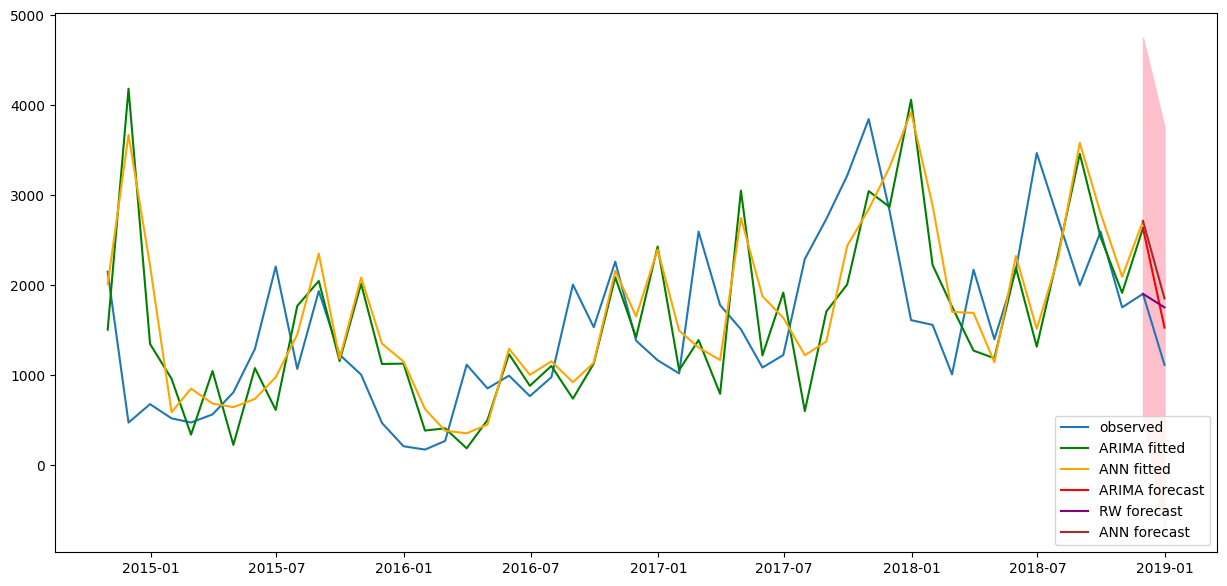

ARIMA MSE: 375.09888879137
RW MSE: 150.0


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Epoch 1/20


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mariumbo\project-thesis\random_walk.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [train[-1]] * len(test)


236/236 [==============================] - 0s 696us/step - loss: 0.0389
Epoch 2/20
236/236 [==============================] - 0s 706us/step - loss: 0.0159
Epoch 3/20
236/236 [==============================] - 0s 598us/step - loss: 0.0098
Epoch 4/20
236/236 [==============================] - 0s 582us/step - loss: 0.0067
Epoch 5/20
236/236 [==============================] - 0s 630us/step - loss: 0.0050
Epoch 6/20
236/236 [==============================] - 0s 587us/step - loss: 0.0042
Epoch 7/20
236/236 [==============================] - 0s 679us/step - loss: 0.0039
Epoch 8/20
236/236 [==============================] - 0s 655us/step - loss: 0.0037
Epoch 9/20
236/236 [==============================] - 0s 630us/step - loss: 0.0035
Epoch 10/20
236/236 [==============================] - 0s 622us/step - loss: 0.0036
Epoch 11/20
236/236 [==============================] - 0s 590us/step - loss: 0.0035
Epoch 12/20
236/236 [==============================] - 0s 630us/step - loss: 0.0036
Epoch 13/20


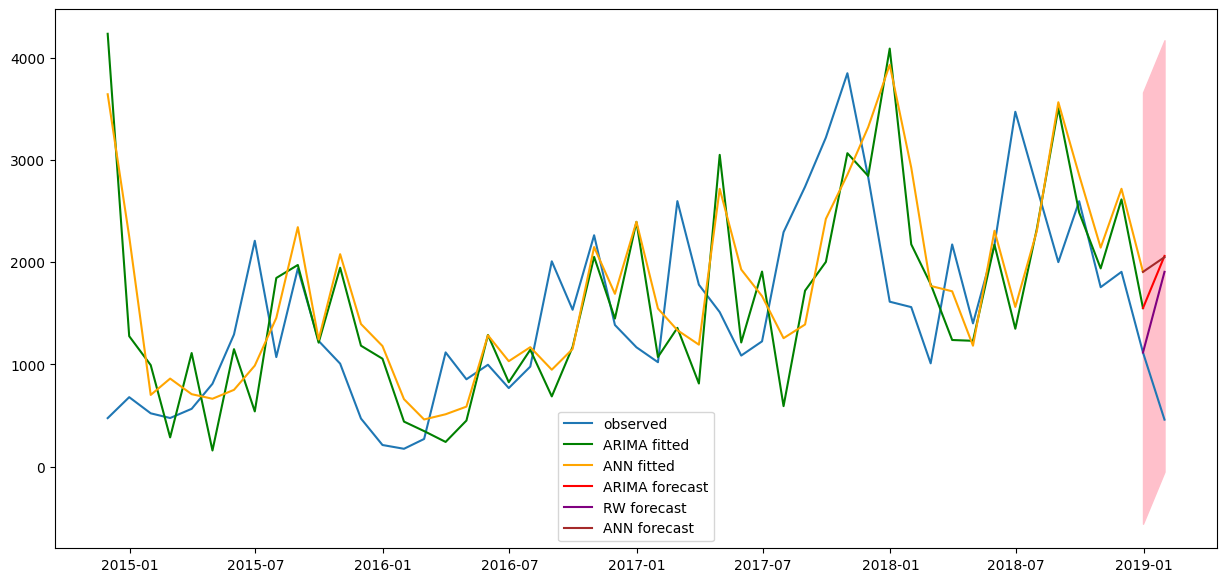

ARIMA MSE: 944.4874498956701
RW MSE: 789.0


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Epoch 1/20


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mariumbo\project-thesis\random_walk.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [train[-1]] * len(test)


237/237 [==============================] - 0s 655us/step - loss: 0.0100
Epoch 2/20
237/237 [==============================] - 0s 632us/step - loss: 0.0047
Epoch 3/20
237/237 [==============================] - 0s 628us/step - loss: 0.0039
Epoch 4/20
237/237 [==============================] - 0s 623us/step - loss: 0.0038
Epoch 5/20
237/237 [==============================] - 0s 671us/step - loss: 0.0038
Epoch 6/20
237/237 [==============================] - 0s 699us/step - loss: 0.0036
Epoch 7/20
237/237 [==============================] - 0s 600us/step - loss: 0.0037
Epoch 8/20
237/237 [==============================] - 0s 643us/step - loss: 0.0036
Epoch 9/20
237/237 [==============================] - 0s 607us/step - loss: 0.0037
Epoch 10/20
237/237 [==============================] - 0s 648us/step - loss: 0.0036
Epoch 11/20
237/237 [==============================] - 0s 613us/step - loss: 0.0037
Epoch 12/20
237/237 [==============================] - 0s 634us/step - loss: 0.0035
Epoch 13/20


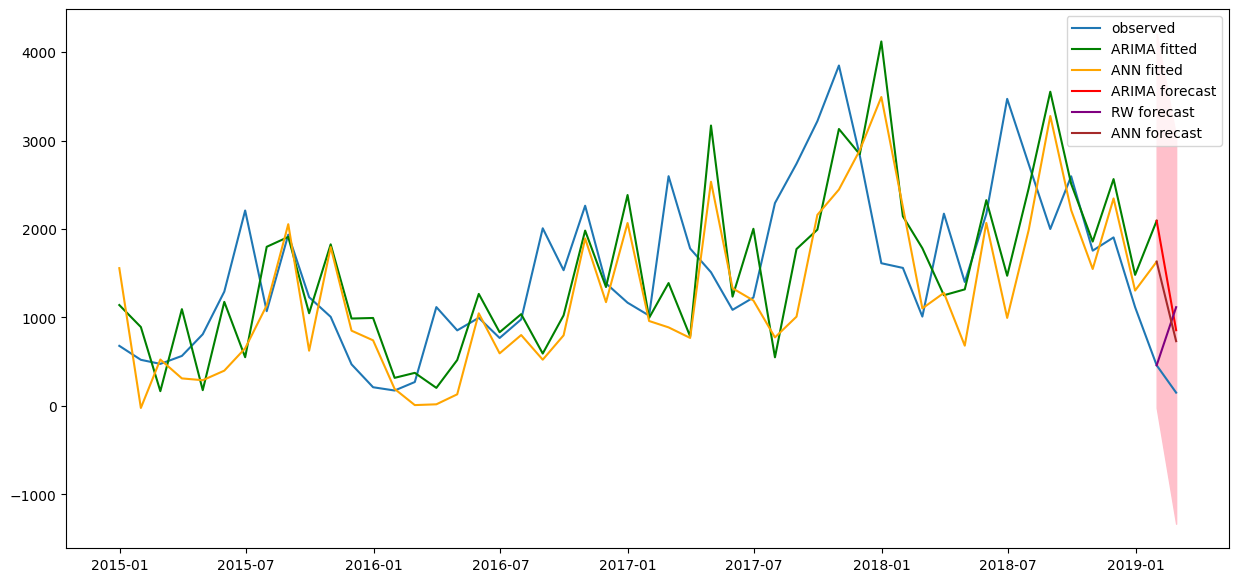

ARIMA MSE: 396.5669190132779
RW MSE: 657.0


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Epoch 1/20


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mariumbo\project-thesis\random_walk.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [train[-1]] * len(test)


238/238 [==============================] - 0s 708us/step - loss: 0.0837
Epoch 2/20
238/238 [==============================] - 0s 674us/step - loss: 0.0334
Epoch 3/20
238/238 [==============================] - 0s 629us/step - loss: 0.0136
Epoch 4/20
238/238 [==============================] - 0s 593us/step - loss: 0.0070
Epoch 5/20
238/238 [==============================] - 0s 661us/step - loss: 0.0049
Epoch 6/20
238/238 [==============================] - 0s 643us/step - loss: 0.0043
Epoch 7/20
238/238 [==============================] - 0s 631us/step - loss: 0.0042
Epoch 8/20
238/238 [==============================] - 0s 629us/step - loss: 0.0041
Epoch 9/20
238/238 [==============================] - 0s 671us/step - loss: 0.0040
Epoch 10/20
238/238 [==============================] - 0s 602us/step - loss: 0.0040
Epoch 11/20
238/238 [==============================] - 0s 625us/step - loss: 0.0040
Epoch 12/20
238/238 [==============================] - 0s 629us/step - loss: 0.0039
Epoch 13/20


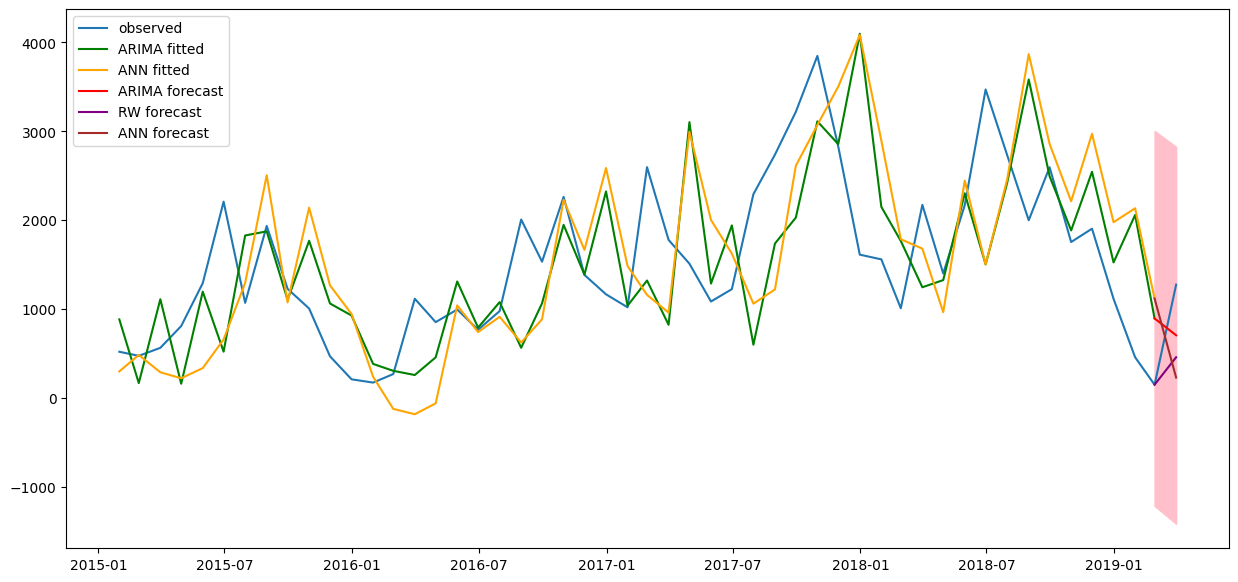

ARIMA MSE: 556.1480239378516
RW MSE: 309.0


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Epoch 1/20


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mariumbo\project-thesis\random_walk.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [train[-1]] * len(test)


239/239 [==============================] - 0s 778us/step - loss: 0.0319
Epoch 2/20
239/239 [==============================] - 0s 622us/step - loss: 0.0099
Epoch 3/20
239/239 [==============================] - 0s 632us/step - loss: 0.0060
Epoch 4/20
239/239 [==============================] - 0s 609us/step - loss: 0.0049
Epoch 5/20
239/239 [==============================] - 0s 660us/step - loss: 0.0044
Epoch 6/20
239/239 [==============================] - 0s 621us/step - loss: 0.0039
Epoch 7/20
239/239 [==============================] - 0s 612us/step - loss: 0.0037
Epoch 8/20
239/239 [==============================] - 0s 617us/step - loss: 0.0036
Epoch 9/20
239/239 [==============================] - 0s 614us/step - loss: 0.0036
Epoch 10/20
239/239 [==============================] - 0s 622us/step - loss: 0.0036
Epoch 11/20
239/239 [==============================] - 0s 613us/step - loss: 0.0035
Epoch 12/20
239/239 [==============================] - 0s 568us/step - loss: 0.0036
Epoch 13/20


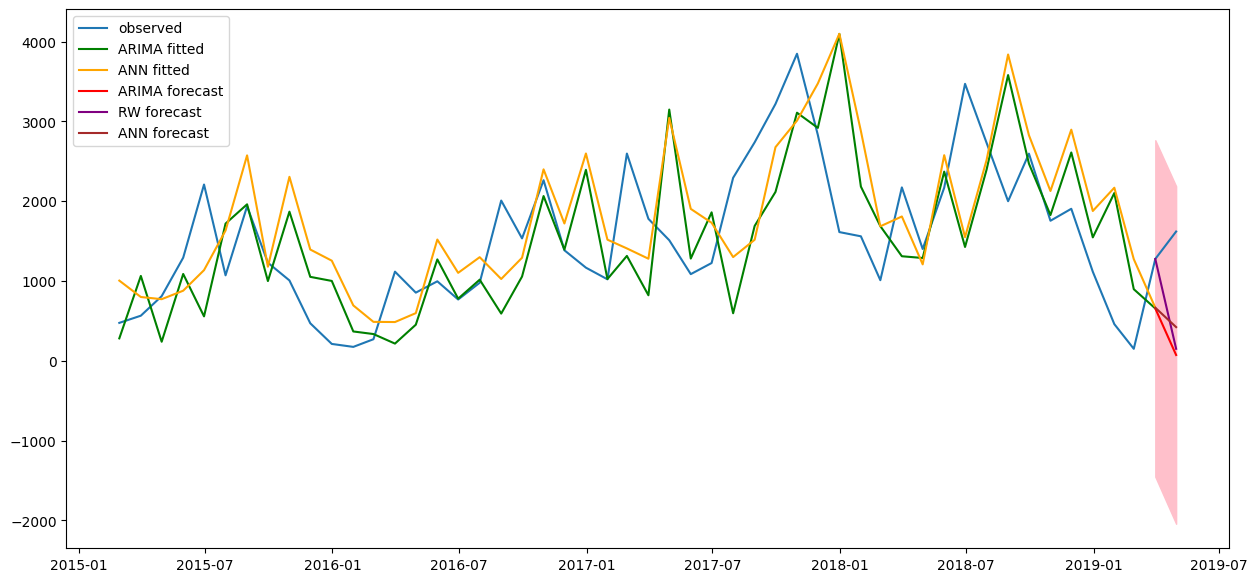

ARIMA MSE: 1203.7881238900343
RW MSE: 1126.0


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Epoch 1/20


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mariumbo\project-thesis\random_walk.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [train[-1]] * len(test)


240/240 [==============================] - 0s 779us/step - loss: 0.0047
Epoch 2/20
240/240 [==============================] - 0s 687us/step - loss: 0.0044
Epoch 3/20
240/240 [==============================] - 0s 642us/step - loss: 0.0044
Epoch 4/20
240/240 [==============================] - 0s 624us/step - loss: 0.0044
Epoch 5/20
240/240 [==============================] - 0s 624us/step - loss: 0.0043
Epoch 6/20
240/240 [==============================] - 0s 624us/step - loss: 0.0041
Epoch 7/20
240/240 [==============================] - 0s 637us/step - loss: 0.0040
Epoch 8/20
240/240 [==============================] - 0s 595us/step - loss: 0.0043
Epoch 9/20
240/240 [==============================] - 0s 669us/step - loss: 0.0041
Epoch 10/20
240/240 [==============================] - 0s 641us/step - loss: 0.0041
Epoch 11/20
240/240 [==============================] - 0s 641us/step - loss: 0.0040
Epoch 12/20
240/240 [==============================] - 0s 624us/step - loss: 0.0041
Epoch 13/20


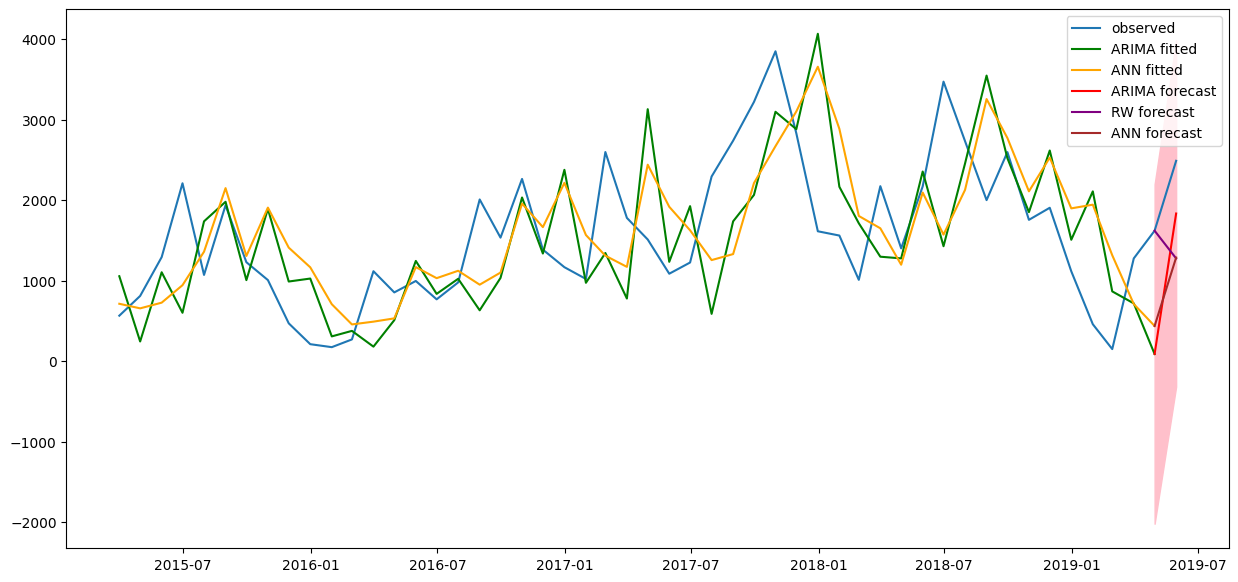

ARIMA MSE: 213.62487478435105
RW MSE: 344.0


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Epoch 1/20


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mariumbo\project-thesis\random_walk.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [train[-1]] * len(test)


241/241 [==============================] - 0s 643us/step - loss: 0.0095
Epoch 2/20
241/241 [==============================] - 0s 609us/step - loss: 0.0065
Epoch 3/20
241/241 [==============================] - 0s 617us/step - loss: 0.0059
Epoch 4/20
241/241 [==============================] - 0s 615us/step - loss: 0.0057
Epoch 5/20
241/241 [==============================] - 0s 620us/step - loss: 0.0053
Epoch 6/20
241/241 [==============================] - 0s 618us/step - loss: 0.0053
Epoch 7/20
241/241 [==============================] - 0s 617us/step - loss: 0.0050
Epoch 8/20
241/241 [==============================] - 0s 621us/step - loss: 0.0049
Epoch 9/20
241/241 [==============================] - 0s 625us/step - loss: 0.0048
Epoch 10/20
241/241 [==============================] - 0s 630us/step - loss: 0.0047
Epoch 11/20
241/241 [==============================] - 0s 624us/step - loss: 0.0046
Epoch 12/20
241/241 [==============================] - 0s 591us/step - loss: 0.0044
Epoch 13/20


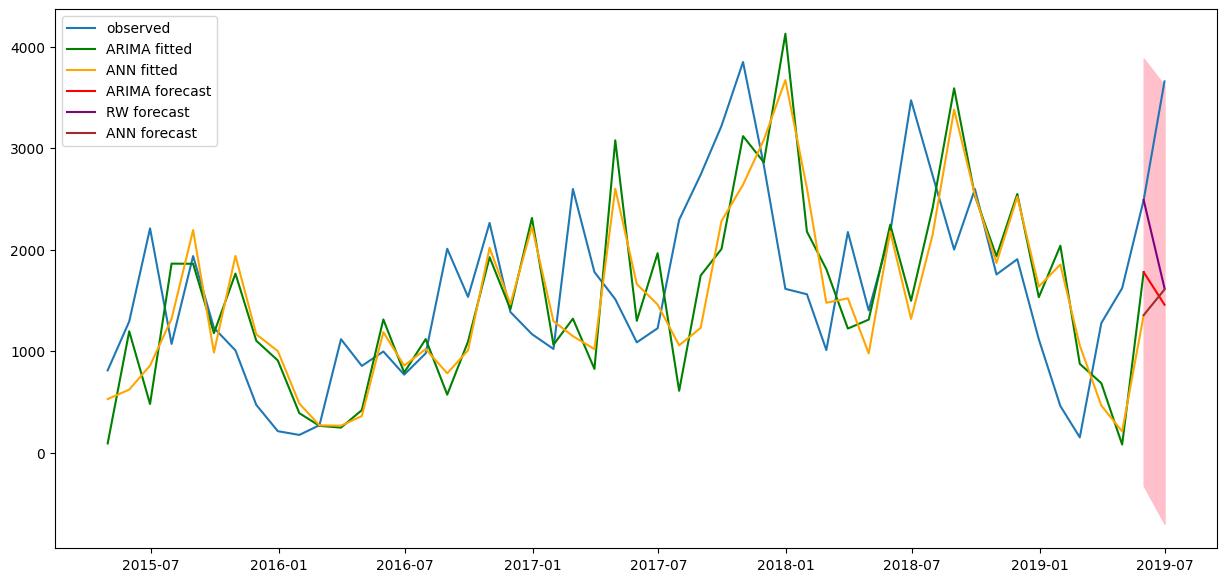

ARIMA MSE: 1030.825532091317
RW MSE: 868.0


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Epoch 1/20


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mariumbo\project-thesis\random_walk.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [train[-1]] * len(test)


242/242 [==============================] - 0s 687us/step - loss: 0.0301
Epoch 2/20
242/242 [==============================] - 0s 626us/step - loss: 0.0127
Epoch 3/20
242/242 [==============================] - 0s 627us/step - loss: 0.0081
Epoch 4/20
242/242 [==============================] - 0s 631us/step - loss: 0.0059
Epoch 5/20
242/242 [==============================] - 0s 604us/step - loss: 0.0048
Epoch 6/20
242/242 [==============================] - 0s 649us/step - loss: 0.0043
Epoch 7/20
242/242 [==============================] - 0s 627us/step - loss: 0.0040
Epoch 8/20
242/242 [==============================] - 0s 627us/step - loss: 0.0037
Epoch 9/20
242/242 [==============================] - 0s 718us/step - loss: 0.0037
Epoch 10/20
242/242 [==============================] - 0s 646us/step - loss: 0.0036
Epoch 11/20
242/242 [==============================] - 0s 627us/step - loss: 0.0036
Epoch 12/20
242/242 [==============================] - 0s 631us/step - loss: 0.0035
Epoch 13/20


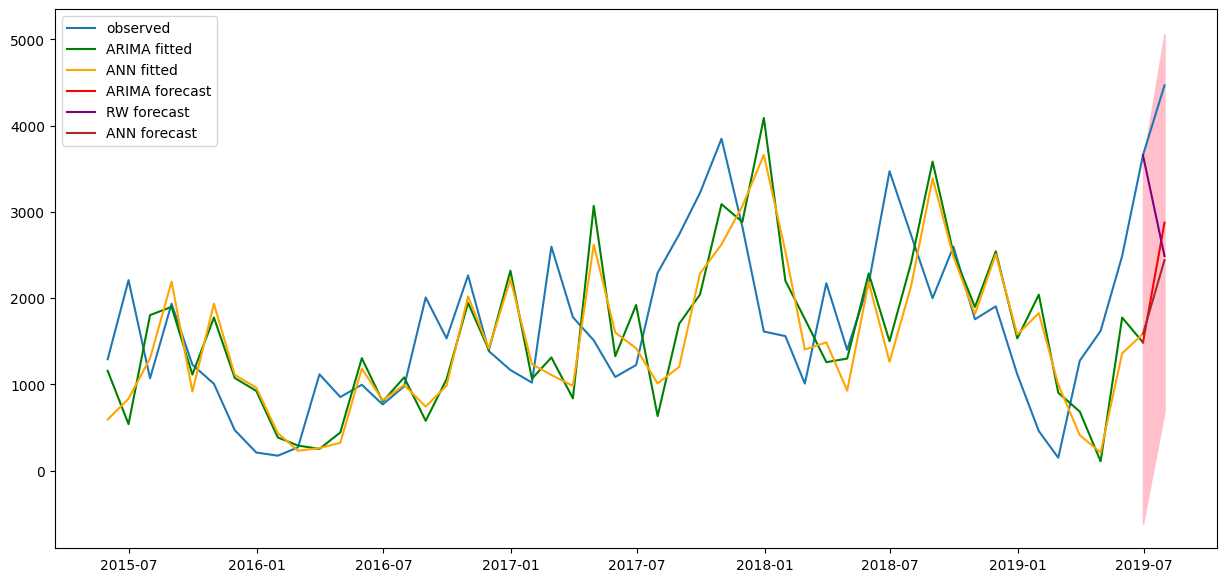

ARIMA MSE: 782.3128871521549
RW MSE: 1169.0


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Epoch 1/20


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mariumbo\project-thesis\random_walk.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [train[-1]] * len(test)


243/243 [==============================] - 0s 685us/step - loss: 0.0265
Epoch 2/20
243/243 [==============================] - 0s 637us/step - loss: 0.0144
Epoch 3/20
243/243 [==============================] - 0s 629us/step - loss: 0.0097
Epoch 4/20
243/243 [==============================] - 0s 590us/step - loss: 0.0063
Epoch 5/20
243/243 [==============================] - 0s 663us/step - loss: 0.0044
Epoch 6/20
243/243 [==============================] - 0s 574us/step - loss: 0.0038
Epoch 7/20
243/243 [==============================] - 0s 619us/step - loss: 0.0036
Epoch 8/20
243/243 [==============================] - 0s 622us/step - loss: 0.0036
Epoch 9/20
243/243 [==============================] - 0s 631us/step - loss: 0.0036
Epoch 10/20
243/243 [==============================] - 0s 633us/step - loss: 0.0037
Epoch 11/20
243/243 [==============================] - 0s 628us/step - loss: 0.0036
Epoch 12/20
243/243 [==============================] - 0s 629us/step - loss: 0.0036
Epoch 13/20


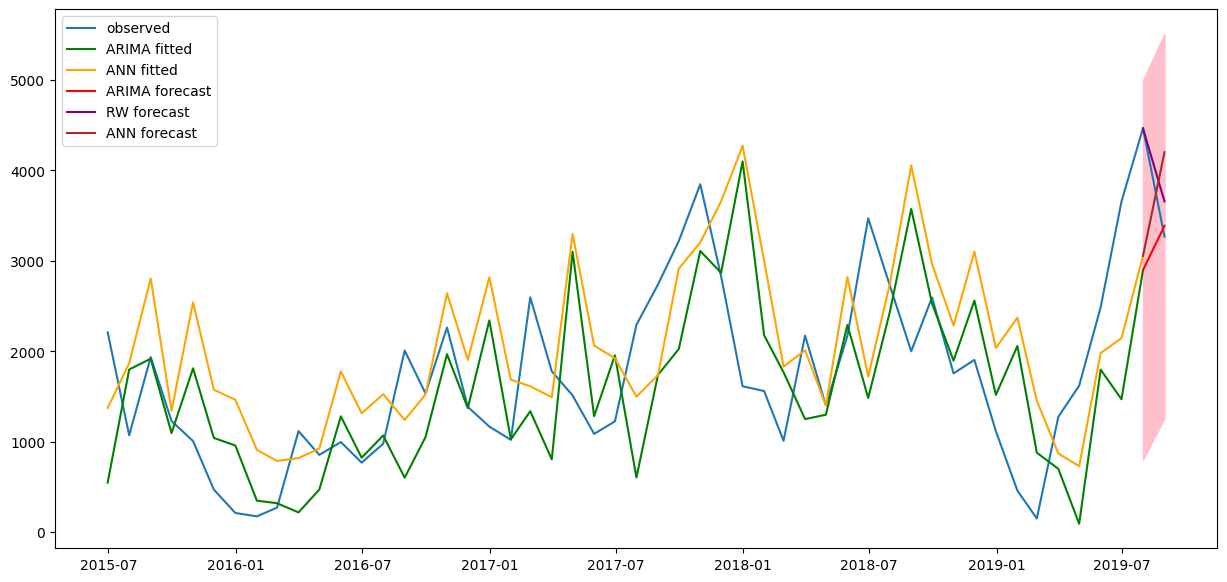

ARIMA MSE: 1079.7271215807154
RW MSE: 810.0


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Epoch 1/20


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mariumbo\project-thesis\random_walk.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [train[-1]] * len(test)


244/244 [==============================] - 0s 683us/step - loss: 0.0471
Epoch 2/20
244/244 [==============================] - 0s 617us/step - loss: 0.0268
Epoch 3/20
244/244 [==============================] - 0s 643us/step - loss: 0.0192
Epoch 4/20
244/244 [==============================] - 0s 626us/step - loss: 0.0136
Epoch 5/20
244/244 [==============================] - 0s 616us/step - loss: 0.0100
Epoch 6/20
244/244 [==============================] - 0s 614us/step - loss: 0.0078
Epoch 7/20
244/244 [==============================] - 0s 622us/step - loss: 0.0065
Epoch 8/20
244/244 [==============================] - 0s 618us/step - loss: 0.0059
Epoch 9/20
244/244 [==============================] - 0s 716us/step - loss: 0.0054
Epoch 10/20
244/244 [==============================] - 0s 632us/step - loss: 0.0050
Epoch 11/20
244/244 [==============================] - 0s 618us/step - loss: 0.0047
Epoch 12/20
244/244 [==============================] - 0s 620us/step - loss: 0.0047
Epoch 13/20


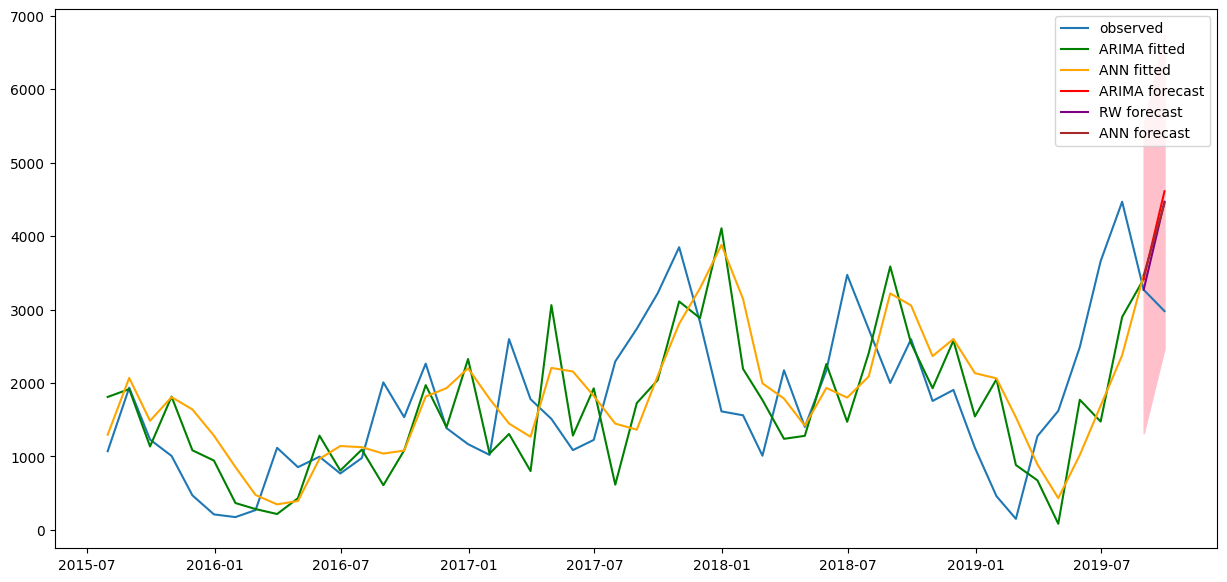

ARIMA MSE: 1340.6404653838272
RW MSE: 1198.0


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Epoch 1/20


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mariumbo\project-thesis\random_walk.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [train[-1]] * len(test)


245/245 [==============================] - 0s 707us/step - loss: 0.0086
Epoch 2/20
245/245 [==============================] - 0s 656us/step - loss: 0.0059
Epoch 3/20
245/245 [==============================] - 0s 658us/step - loss: 0.0054
Epoch 4/20
245/245 [==============================] - 0s 696us/step - loss: 0.0051
Epoch 5/20
245/245 [==============================] - 0s 635us/step - loss: 0.0049
Epoch 6/20
245/245 [==============================] - 0s 640us/step - loss: 0.0046
Epoch 7/20
245/245 [==============================] - 0s 642us/step - loss: 0.0045
Epoch 8/20
245/245 [==============================] - 0s 636us/step - loss: 0.0040
Epoch 9/20
245/245 [==============================] - 0s 651us/step - loss: 0.0041
Epoch 10/20
245/245 [==============================] - 0s 587us/step - loss: 0.0040
Epoch 11/20
245/245 [==============================] - 0s 644us/step - loss: 0.0038
Epoch 12/20
245/245 [==============================] - 0s 640us/step - loss: 0.0039
Epoch 13/20


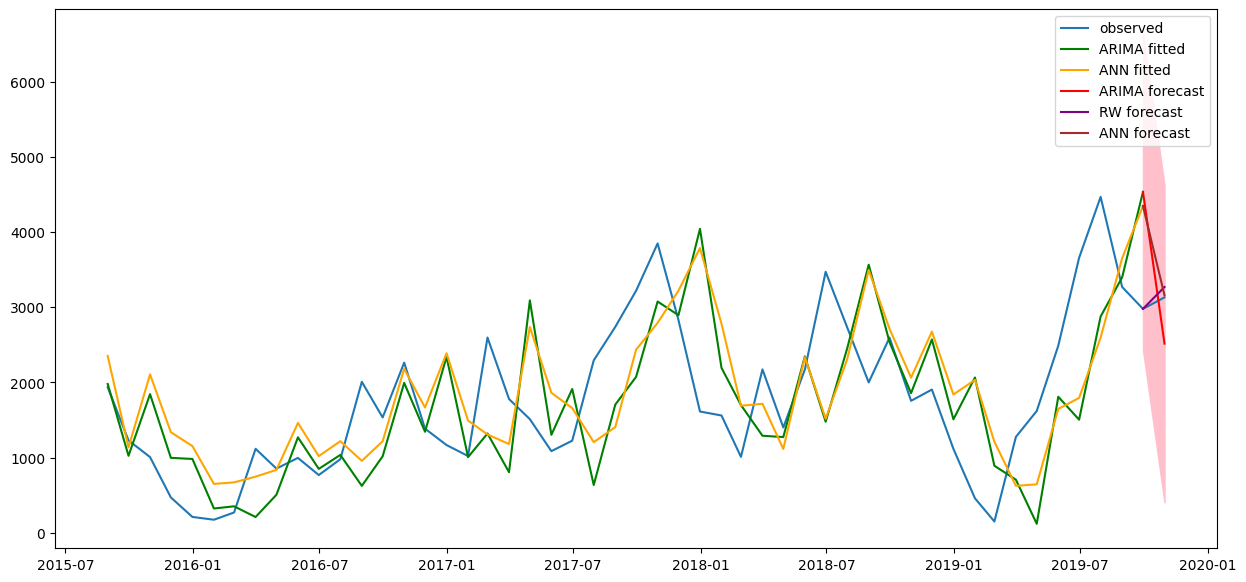

ARIMA MSE: 461.97398416247097
RW MSE: 291.0


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Epoch 1/20


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mariumbo\project-thesis\random_walk.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [train[-1]] * len(test)


246/246 [==============================] - 0s 632us/step - loss: 0.0115
Epoch 2/20
246/246 [==============================] - 0s 632us/step - loss: 0.0064
Epoch 3/20
246/246 [==============================] - 0s 633us/step - loss: 0.0049
Epoch 4/20
246/246 [==============================] - 0s 627us/step - loss: 0.0043
Epoch 5/20
246/246 [==============================] - 0s 630us/step - loss: 0.0041
Epoch 6/20
246/246 [==============================] - 0s 625us/step - loss: 0.0039
Epoch 7/20
246/246 [==============================] - 0s 625us/step - loss: 0.0038
Epoch 8/20
246/246 [==============================] - 0s 632us/step - loss: 0.0038
Epoch 9/20
246/246 [==============================] - 0s 629us/step - loss: 0.0039
Epoch 10/20
246/246 [==============================] - 0s 633us/step - loss: 0.0036
Epoch 11/20
246/246 [==============================] - 0s 634us/step - loss: 0.0037
Epoch 12/20
246/246 [==============================] - 0s 634us/step - loss: 0.0036
Epoch 13/20


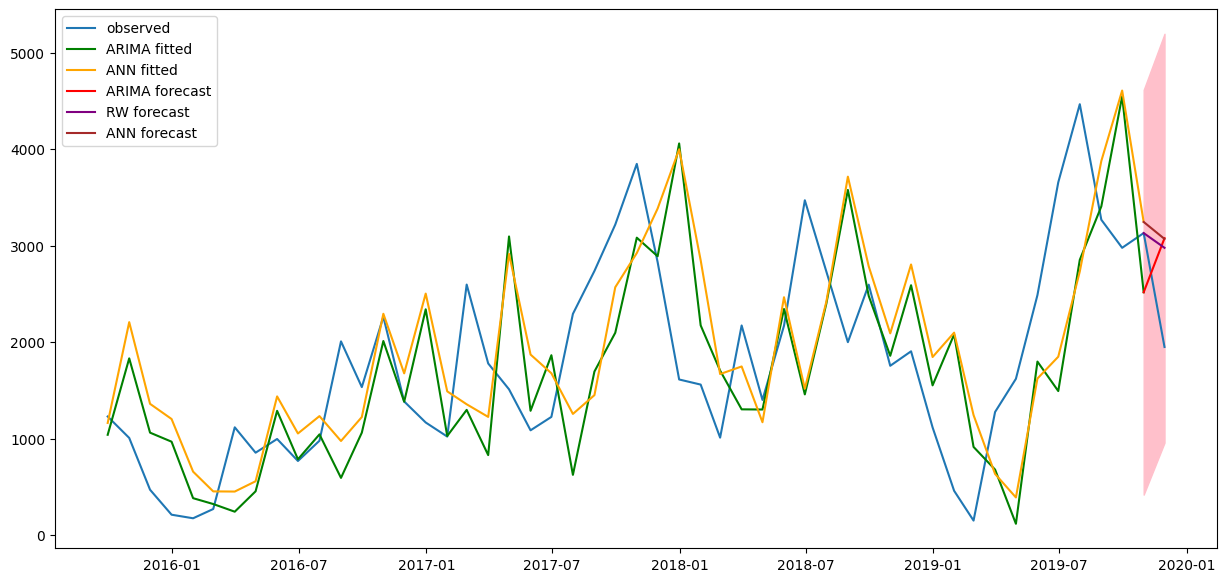

ARIMA MSE: 53.42828359344003
RW MSE: 153.0


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Epoch 1/20


c:\Users\mariumbo\project-thesis\random_walk.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [train[-1]] * len(test)


247/247 [==============================] - 0s 640us/step - loss: 0.0736
Epoch 2/20
247/247 [==============================] - 0s 639us/step - loss: 0.0328
Epoch 3/20
247/247 [==============================] - 0s 634us/step - loss: 0.0228
Epoch 4/20
247/247 [==============================] - 0s 642us/step - loss: 0.0162
Epoch 5/20
247/247 [==============================] - 0s 623us/step - loss: 0.0115
Epoch 6/20
247/247 [==============================] - 0s 633us/step - loss: 0.0082
Epoch 7/20
247/247 [==============================] - 0s 627us/step - loss: 0.0063
Epoch 8/20
247/247 [==============================] - 0s 633us/step - loss: 0.0053
Epoch 9/20
247/247 [==============================] - 0s 635us/step - loss: 0.0047
Epoch 10/20
247/247 [==============================] - 0s 626us/step - loss: 0.0044
Epoch 11/20
247/247 [==============================] - 0s 630us/step - loss: 0.0044
Epoch 12/20
247/247 [==============================] - 0s 635us/step - loss: 0.0043
Epoch 13/20


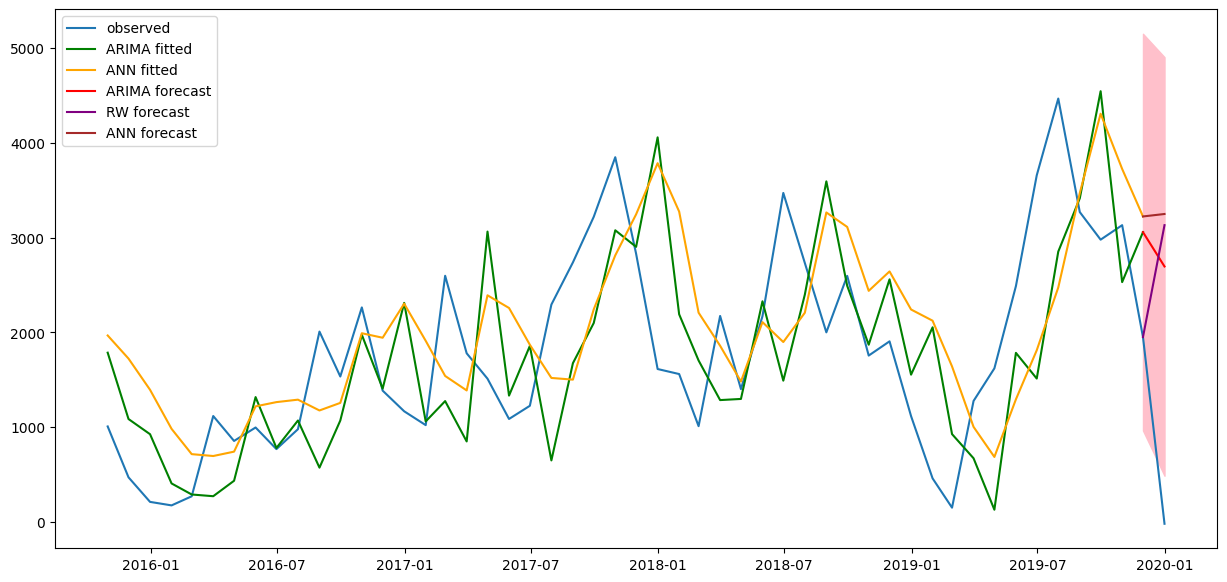

ARIMA MSE: 745.1655989833539
RW MSE: 1181.0


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Epoch 1/20


c:\Users\mariumbo\project-thesis\random_walk.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [train[-1]] * len(test)


248/248 [==============================] - 0s 685us/step - loss: 0.0087
Epoch 2/20
248/248 [==============================] - 0s 627us/step - loss: 0.0043
Epoch 3/20
248/248 [==============================] - 0s 575us/step - loss: 0.0036
Epoch 4/20
248/248 [==============================] - 0s 632us/step - loss: 0.0037
Epoch 5/20
248/248 [==============================] - 0s 632us/step - loss: 0.0036
Epoch 6/20
248/248 [==============================] - 0s 636us/step - loss: 0.0035
Epoch 7/20
248/248 [==============================] - 0s 640us/step - loss: 0.0037
Epoch 8/20
248/248 [==============================] - 0s 642us/step - loss: 0.0036
Epoch 9/20
248/248 [==============================] - 0s 660us/step - loss: 0.0036
Epoch 10/20
248/248 [==============================] - 0s 635us/step - loss: 0.0035
Epoch 11/20
248/248 [==============================] - 0s 719us/step - loss: 0.0035
Epoch 12/20
248/248 [==============================] - 0s 644us/step - loss: 0.0036
Epoch 13/20


In [17]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from arima_forecasts import ARIMA_forecast_wrapper
from random_walk import random_walk_forecast
from helper_functions import compute_rmse, load_monthly_baci_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Prepare the dataset
def create_ann_dataset(data, lookback, is_test=False, ):
    X, y = [], []
    if is_test:  # for test data, we just need the last entry for 1-step ahead forecast
        X.append(data[-lookback:])
        return np.array(X).reshape(1, lookback, 1), None
    else:
        for i in range(lookback, len(data)):
            X.append(data[i-lookback:i])
            y.append(data[i])
        return np.array(X), np.array(y)

# Design the ANN model
def create_ann_model(lookback):
    model = Sequential()
    model.add(Dense(8, input_dim=lookback, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def ANN_forecast(train, test, steps_ahead, lookback=2):
    # Rescale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
    test_scaled = scaler.transform(test.values.reshape(-1, 1))
    
    X_train, y_train = create_ann_dataset(train_scaled, lookback)
    
    model = create_ann_model(lookback)
    model.fit(X_train, y_train, epochs=20, batch_size=1)
    scaled_fitted_values = model.predict(X_train)
    fitted_values = scaler.inverse_transform(scaled_fitted_values)

     # Starting with the last 'lookback' data points from the training set
    input_data = train_scaled[-lookback:]
    
    # List to store forecasted points
    scaled_forecast = []

    # Iteratively predict steps ahead
    for _ in range(steps_ahead):
        X_test, _ = create_ann_dataset(input_data, lookback, is_test=True)
        prediction = model.predict(X_test)
        scaled_forecast.append(prediction[0][0])  # Add the new prediction
        
        # Append the new prediction to the end of input_data and remove the oldest value
        input_data = np.append(input_data[1:], prediction)
    # Inverse the scaling on the forecasted values
    forecast = scaler.inverse_transform(np.array(scaled_forecast).reshape(-1, 1))
    
    return forecast.flatten(), fitted_values

def ARIMA_vs_RW_vs_ANN(data, train_ratio=0.8, months_ahead=1, n_forecasts=1, plot=False):

    def plot_forecast(arima_mean_forecast, arima_forecast, arima_model, random_walk_forecast, ann_forecast, ann_fitted_values, res=15):
        true_values = data["CLOSE"]
        arima_fitted_values = arima_model.fittedvalues

        # Append the last fitted value to the forecasted values

        # Plot
        # Get standard error from the model fit
        std_error = np.std(arima_model.resid)

        # Plot
        plt.figure(figsize=(15,7))
        plt.plot(true_values.iloc[:train_size + months_ahead - 1][-res - months_ahead:].index, true_values.iloc[:train_size + months_ahead][-res - months_ahead:].values, label='observed')
        plt.plot(arima_fitted_values.index[-res:], arima_fitted_values[-res:].values, color='green', label='ARIMA fitted')
        plt.plot(arima_fitted_values.index[-res:], ann_fitted_values[-res:], color='orange', label='ANN fitted')


        # Combined forecast values including the last fitted value
        arima_forecast_values = np.insert(arima_mean_forecast.values, 0, arima_fitted_values.values[-1])
        random_walk_forecast_values = np.insert(random_walk_forecast, 0, true_values.iloc[train_size - 1])
        ann_forecast_values = np.insert(ann_forecast, 0, ann_fitted_values[-1])

        forecast_dates = pd.date_range(start=arima_fitted_values.index[-1], periods=len(arima_forecast_values), freq='M')
        plt.plot(forecast_dates, arima_forecast_values, color='red', label='ARIMA forecast')
        plt.plot(forecast_dates, random_walk_forecast_values, color="purple", label="RW forecast")
        plt.plot(forecast_dates, ann_forecast_values, color="brown", label="ANN forecast")

        if arima_forecast.conf_int() is not None:
            # Create confidence intervals for the last fitted value
            conf_int_last_fitted = [
                arima_fitted_values.values[-1] - 1.96 * std_error,  # lower bound
                arima_fitted_values.values[-1] + 1.96 * std_error   # upper bound
            ]

            # Append these intervals to the forecasted confidence intervals
            conf_int_values = np.vstack((
                conf_int_last_fitted,
                arima_forecast.conf_int().values
            ))

            # Fill between for combined confidence intervals
            plt.fill_between(forecast_dates, conf_int_values[:, 0], conf_int_values[:, 1], color='pink')

        plt.legend()
        plt.show()
        print(f"ARIMA MSE: {compute_rmse(test, arima_mean_forecast)}")
        print(f"RW MSE: {compute_rmse(test, random_walk_forecast)}")



    train_size = int(train_ratio * len(data))
    arima_rmses, rw_rmses, ann_rmses = [], [], []

    for _ in range(n_forecasts):
        train = data["CLOSE"].iloc[:train_size]
        test = data["CLOSE"].iloc[train_size:train_size + months_ahead]

        # ARIMA forecast
        arima_mean_forecast, arima_forecast, arima_model = ARIMA_forecast_wrapper(train, test, months_ahead)
        arima_rmse = compute_rmse(test, arima_mean_forecast)
        arima_rmses.append(arima_rmse)

        # Random Walk forecast
        rw_forecast = random_walk_forecast(train, test)
        rw_rmse = compute_rmse(test, rw_forecast)
        rw_rmses.append(rw_rmse)

        # ANN forecast
        ann_forecast, ann_fitted_values = ANN_forecast(train=train, test=test, steps_ahead=months_ahead)
        ann_rmse = compute_rmse(test, ann_forecast)
        ann_rmses.append(ann_rmse)

        train_size += months_ahead

        if plot:
            plot_forecast(arima_mean_forecast=arima_mean_forecast, 
                          arima_forecast=arima_forecast, 
                          arima_model=arima_model,
                          random_walk_forecast=rw_forecast,
                          ann_forecast=ann_forecast,
                          ann_fitted_values=ann_fitted_values,
                          res=50)


    return arima_rmses, rw_rmses, ann_rmses

df = load_monthly_baci_data()
arima_rmses, rw_rmses, ann_rmses = ARIMA_vs_RW_vs_ANN(df, n_forecasts=20, months_ahead=1, plot=True)
print(f"ARIMA RMSEs: {np.average(arima_rmses)}")
print(f"Random Walk RMSEs: {np.average(rw_rmses)}")
print(f"ANN RMSEs: {np.average(ann_rmses)}")
